https://docs.pymc.io/notebooks/GP-MeansAndCovs.html

In [76]:

import matplotlib.pyplot as plt
import matplotlib.cm as cmap

import numpy as np
import scipy as sp
import pandas as pd
np.random.seed(42)

import theano
import theano.tensor as tt
import pymc3 as pm



### Mean functions

The following mean functions are available in PyMC3.

    - gp.mean.Zero
    - gp.mean.Constant
    - gp.mean.Li

### Zero
(The default mean functions for all GP implementations in PyMC3 is Zero.)

In [2]:
zero_func = pm.gp.mean.Zero()

X = np.linspace(0, 1, 5)[:, None]
zero_func(X).eval()

array([0., 0., 0., 0., 0.], dtype=float32)

### Constant

In [4]:
const_func = pm.gp.mean.Constant(25.2)

const_func(X).eval()

array([25.2, 25.2, 25.2, 25.2, 25.2])

As long as the shape matches the input it will receive, gp.mean.Constant can also accept a Theano tensor or vector of PyMC3 random variables.

In [5]:
const_func_vec = pm.gp.mean.Constant(tt.ones(5))
const_func_vec(X).eval()

array([1., 1., 1., 1., 1.])

### Linear
gp.mean.Linear is a takes as input a matrix of coefficients and a vector of intercepts (or a slope and scalar intercept in one dimension).

In [32]:
beta = 5#np.random.randn(3) 
b = 0.0

lin_func = pm.gp.mean.Linear(coeffs=beta, intercept=b)

X = np.random.randn(10) #  np.random.randn(5, 3)
y = lin_func(X).eval()
y

array([ 2.36796215, -4.59712117,  7.74967203, -3.91626646, -1.61030758,
        4.06758609, -6.15432158,  1.13729967,  6.53571377, -8.03741617])

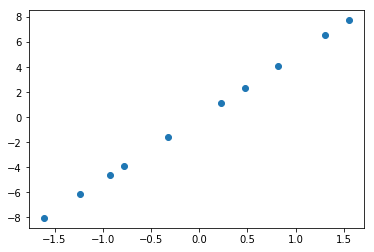

In [33]:
plt.plot(X,y,'o')
plt.show()

See a lot more on https://docs.pymc.io/notebooks/GP-MeansAndCovs.html

# Marginal Likelihood Implementation¶

In [34]:
# A one dimensional column vector of inputs.
X = np.linspace(0, 1, 10)[:,None] # same as .reshape(-1,1)

with pm.Model() as marginal_gp_model:
    
    # Specify the covariance function. Here RBF
    cov_func = pm.gp.cov.ExpQuad(1, ls=0.1)

    # Specify the GP.  The default mean function is `Zero`.
    gp = pm.gp.Marginal(cov_func=cov_func)

    # The scale of the white noise term can be provided,
    sigma = pm.HalfCauchy("sigma", beta=5)
    y_ = gp.marginal_likelihood("y_", X=X, y=y, noise=sigma)

    # OR a covariance function for the noise can be given
    # noise_l = pm.Gamma("noise_l", alpha=2, beta=2)
    # cov_func_noise = pm.gp.cov.Exponential(1, noise_l) + pm.gp.cov.WhiteNoise(sigma=0.1)
    # y_ = gp.marginal_likelihood("y", X=X, y=y, noise=cov_func_noise)



In [38]:
Xnew = np.linspace(0, 2, 100)[:, None]

with marginal_gp_model:
    f_star = gp.conditional("f_star", Xnew=Xnew)

    # or to predict the GP plus noise
    y_star = gp.conditional("y_star", Xnew=Xnew, pred_noise=True)

In [54]:
with marginal_gp_model:
    trace = pm.find_MAP()


logp = 177.59, ||grad|| = 3.987: : 5001it [03:22, 24.72it/s]



In [61]:
# The mean and full covariance
mu, cov = gp.predict(Xnew)

# The mean and variance (diagonal of the covariance)
mu, var = gp.predict(Xnew,  diag=True)

# With noise included
mu, var = gp.predict(Xnew,  diag=True, pred_noise=True)

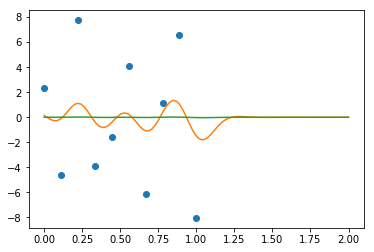

In [75]:
plt.plot(X,y,'o')
plt.plot(Xnew,trace['y_star'],'-')
#plt.plot(Xnew,trace['y_star'] + trace['sigma'], Xnew,trace['y_star'] - trace['sigma'],'-')
#plt.plot(Xnew,trace['f_star'],'-')
plt.plot(Xnew,mu,'-')

plt.show()
# idk...

# Example: Regression with white, Gaussian noise
https://docs.pymc.io/notebooks/GP-Marginal.html

In [78]:
# set the seed
np.random.seed(1)

# The number of data points
n = 100 

# The inputs to the GP, they must be arranged as a column vector. same as .reshape(-1,1)
X = np.linspace(0, 10, n)[:, None] 

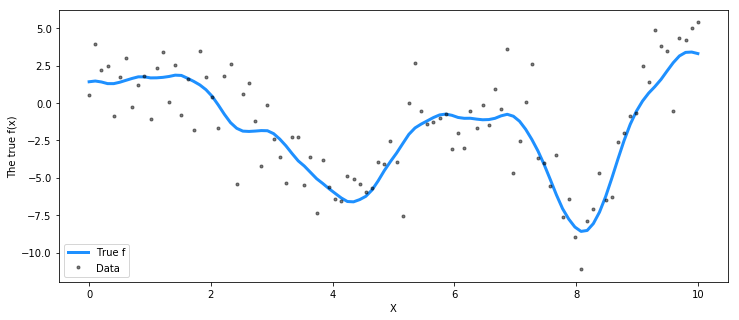

In [80]:

# Define the true covariance function and its parameters
ℓ_true = 1.0
η_true = 3.0
cov_func = η_true**2 * pm.gp.cov.Matern52(1, ℓ_true)

# A mean function that is zero everywhere
mean_func = pm.gp.mean.Zero()

# The latent function values are one sample from a multivariate normal
# Note that we have to call `eval()` because PyMC3 built on top of Theano
f_true = np.random.multivariate_normal(mean_func(X).eval(),
                                       cov_func(X).eval() + 1e-8*np.eye(n), 1).flatten()

# The observed data is the latent function plus a small amount of IID Gaussian noise
# The standard deviation of the noise is `sigma`
σ_true = 2.0
y = f_true + σ_true * np.random.randn(n)

## Plot the data and the unobserved latent function
fig = plt.figure(figsize=(12,5)); ax = fig.gca()

ax.plot(X, f_true, "dodgerblue", lw=3, label="True f")
ax.plot(X, y, 'ok', ms=3, alpha=0.5, label="Data")
ax.set_xlabel("X"); ax.set_ylabel("The true f(x)") 

plt.legend()

plt.show()

In [96]:
# the model

with pm.Model() as model:
    ℓ = pm.Gamma("ℓ", alpha=2, beta=1)
    η = pm.HalfCauchy("η", beta=5)

    cov = η**2 * pm.gp.cov.Matern52(1, ℓ)
    gp = pm.gp.Marginal(cov_func=cov)

    σ = pm.HalfCauchy("σ", beta=5)
    y_ = gp.marginal_likelihood("y", X=X, y=y, noise=σ)

    mp = pm.find_MAP()


logp = -231.67, ||grad|| = 0.0013468: 100%|██████████| 12/12 [00:00<00:00, 58.30it/s]  


In [98]:
# collect the results into a pandas dataframe to display
# "mp" stands for marginal posterior
pd.DataFrame({"Parameter": ["ℓ", "η", "σ"],
              "True value": [ℓ_true, η_true, σ_true],
              "Value at MAP": [float(mp["ℓ"]), float(mp["η"]), float(mp["σ"])]})

,Parameter,True value,Value at MAP
0,ℓ,1.0,1.004619
1,η,3.0,3.488940
2,σ,2.0,1.904490


In [89]:
#With sample
with model:
    mp_sample = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO (theano.gof.compilelock): Refreshing lock /home/polichinel/.theano/compiledir_Linux-4.10--generic-x86_64-with-debian-stretch-sid-x86_64-3.6.6-64/lock_dir/lock
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [σ, η, ℓ]
Sampling 4 chains: 100%|██████████| 4000/4000 [05:27<00:00, 12.21draws/s]


In [84]:
# The MAP values are close to their true values.

In [95]:
# collect the results into a pandas dataframe to display
# "mp" stands for marginal posterior
pd.DataFrame({"Parameter": ["ℓ", "η", "σ"],
              "True value": [ℓ_true, η_true, σ_true],
              "Mean of samples": [float(mp_sample["ℓ"].mean()), 
                                  float(mp_sample["η"].mean()), 
                                  float(mp_sample["σ"].mean())]})

,Parameter,True value,Mean of samples
0,ℓ,1.0,1.165909
1,η,3.0,4.377152
2,σ,2.0,1.939001


map was actually better...

### Using .conditional

In [103]:
# new values from x=0 to x=20
X_new = np.linspace(0, 20, 600)[:,None]

# add the GP conditional to the model, given the new X values
with model:
    f_pred = gp.conditional("f_pred", X_new)

# To use the MAP values, you can just replace the trace with a length-1 list with `mp`
with model:
    #pred_samples = pm.sample_posterior_predictive([mp], vars=[f_pred], samples=2000)
    pred_samples = pm.sample_ppc([mp], vars=[f_pred], samples=2000)


100%|██████████| 2000/2000 [31:35<00:00,  1.06it/s]


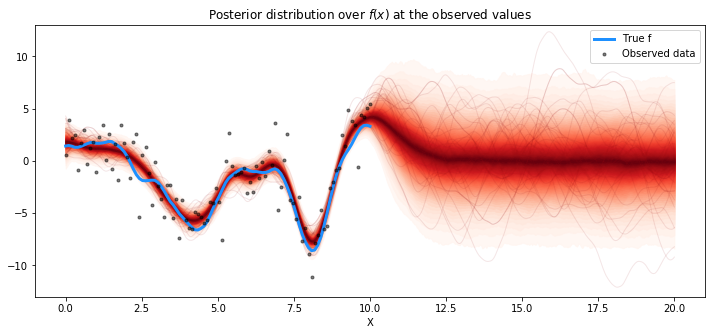

In [104]:
# plot the results
fig = plt.figure(figsize=(12,5)); ax = fig.gca()

# plot the samples from the gp posterior with samples and shading
from pymc3.gp.util import plot_gp_dist
plot_gp_dist(ax, pred_samples["f_pred"], X_new)

# plot the data and the true latent function
plt.plot(X, f_true, "dodgerblue", lw=3, label="True f")
plt.plot(X, y, 'ok', ms=3, alpha=0.5, label="Observed data")

# axis labels and title
plt.xlabel("X"); plt.ylim([-13,13])
plt.title("Posterior distribution over $f(x)$ at the observed values"); plt.legend()

plt.show()

But f_pred is the noiseless function $f_*$ not $f_* + noise$, which is what we actually observe:

$$y = f(x) + \epsilon$$

The conditional method of gp.Marginal contains the flag pred_noise whose default value is False. To draw from the posterior predictive distribution, we simply set this flag to True.

In [105]:
with model:
    y_pred = gp.conditional("y_pred", X_new, pred_noise=True)
    #y_samples = pm.sample_posterior_predictive([mp], vars=[y_pred], samples=2000)
    y_samples = pm.sample_ppc([mp], vars=[y_pred], samples=2000)


INFO (theano.gof.compilelock): Refreshing lock /home/polichinel/.theano/compiledir_Linux-4.10--generic-x86_64-with-debian-stretch-sid-x86_64-3.6.6-64/lock_dir/lock
100%|██████████| 2000/2000 [29:10<00:00,  1.14it/s]


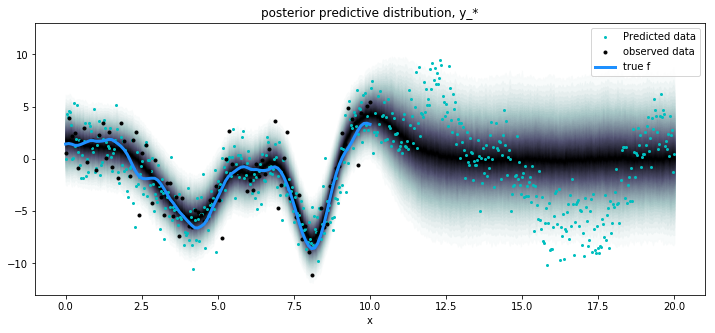

In [106]:
fig = plt.figure(figsize=(12,5)); ax = fig.gca()

# posterior predictive distribution
plot_gp_dist(ax, y_samples["y_pred"], X_new, plot_samples=False, palette="bone_r")

# overlay a scatter of one draw of random points from the
#  posterior predictive distribution
plt.plot(X_new, y_samples["y_pred"][800, :].T, "co", ms=2, label="Predicted data")

# plot original data and true function
plt.plot(X, y, 'ok', ms=3, alpha=1.0, label="observed data")
plt.plot(X, f_true, "dodgerblue", lw=3, label="true f")

plt.xlabel("x"); plt.ylim([-13,13]);
plt.title("posterior predictive distribution, y_*")
plt.legend()

plt.show()

Notice that the posterior predictive density is wider than the conditional distribution of the noiseless function, and reflects the predictive distribution of the noisy data, which is marked as black dots. The light colored dots don’t follow the spread of the predictive density exactly because they are a single draw from the posterior of the GP plus noise.

### konk.
Still all to slow.. Below I look at sparse optimizations, but that does not really fit the problem. 

Can I use map above? can I use GPU? All cores?
try it out:

### Using .predict

We can use the .predict method to return the mean and variance given a particular point. Since we used find_MAP in this example, predict returns the same mean and covariance that the distribution of .conditional has.

INFO (theano.gof.compilelock): Refreshing lock /home/polichinel/.theano/compiledir_Linux-4.10--generic-x86_64-with-debian-stretch-sid-x86_64-3.6.6-64/lock_dir/lock


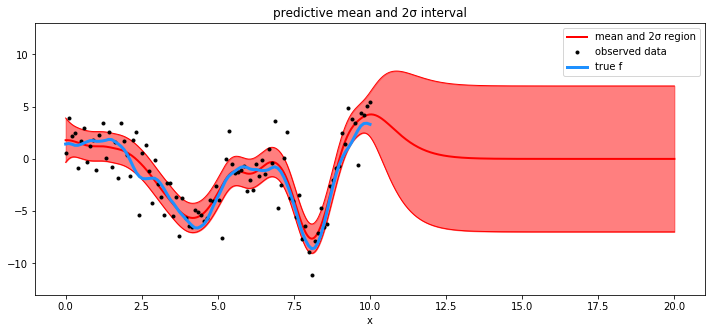

In [107]:

# predict
mu, var = gp.predict(X_new, point=mp, diag=True)
sd = np.sqrt(var)

# draw plot
fig = plt.figure(figsize=(12,5)); ax = fig.gca()

# plot mean and 2σ intervals
plt.plot(X_new, mu, 'r', lw=2, label="mean and 2σ region")
plt.plot(X_new, mu + 2*sd, 'r', lw=1) 
plt.plot(X_new, mu - 2*sd, 'r', lw=1)

plt.fill_between(X_new.flatten(), mu - 2*sd, mu + 2*sd, color="r", alpha=0.5)

# plot original data and true function
plt.plot(X, y, 'ok', ms=3, alpha=1.0, label="observed data")
plt.plot(X, f_true, "dodgerblue", lw=3, label="true f")

plt.xlabel("x"); plt.ylim([-13,13])
plt.title("predictive mean and 2σ interval")
plt.legend()

plt.show()

# Sparse Approximations
https://docs.pymc.io/notebooks/GP-SparseApprox.html

The gp.MarginalSparse class implements sparse, or inducing point, GP approximations. It works identically to gp.Marginal, except it additionally requires the locations of the inducing points (denoted Xu), and it accepts the argument sigma instead of noise because these sparse approximations assume white IID noise.

Three approximations are currently implemented, FITC, DTC and VFE. For most problems, they produce fairly similar results. These GP approximations don’t form the full covariance matrix over all n
training inputs. Instead they rely on m<n inducing points, which are “strategically” placed throughout the domain. Both of these approximations reduce the O(n3) complexity of GPs down to O(nm2)

— a significant speed up. The memory requirements scale down a bit too, but not as much. They are commonly referred to as sparse approximations, in the sense of being data sparse. The downside of sparse approximations is that they reduce the expressiveness of the GP. Reducing the dimension of the covariance matrix effectively reduces the number of covariance matrix eigenvectors that can be used to fit the data.

A choice that needs to be made is where to place the inducing points. One option is to use a subset of the inputs. Another possibility is to use K-means. The location of the inducing points can also be an unknown and optimized as part of the model. These sparse approximations are useful for speeding up calculations when the density of data points is high and the lengthscales is larger than the separations between inducing points.

For more information on these approximations, see Quinonero-Candela+Rasmussen, 2006 and Titsias 2009.